In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import ( Conv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Input, AveragePooling2D)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
import os

# List the files in the extracted directory
files = os.listdir('UTKFace_dataset')
print(files)

['crop_part1', 'UTKFace', 'utkface_aligned_cropped']


In [3]:
path="C:/Users/SAUMIYA/DL MINIPROJECT/UTKFace_dataset/UTKFace"

In [4]:
# Function to reassign age labels
def class_labels_reassign(age):
    if 0 <= age <= 15:
        return 0
    elif 16 <= age <= 30:
        return 1
    elif 31 <= age <= 45:
        return 2
    elif 46 <= age <= 60:
        return 3
    else:
        return 4

In [5]:
pixels = []
ages = []
genders = []

In [6]:
# Read and preprocess images
for img in os.listdir(path):
    age = int(img.split("_")[0])
    gender = int(img.split("_")[1])
    img_path = os.path.join(path, img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    pixels.append(np.array(img))
    ages.append(np.array(age))
    genders.append(np.array(gender))

pixels = np.array(pixels)
ages = np.array(ages)
genders = np.array(genders)


In [7]:
# Reassign age and gender labels
label_ages = np.array([class_labels_reassign(a) for a in ages])
label_genders = genders  # No need to reassign gender labels

pixels = pixels / 255


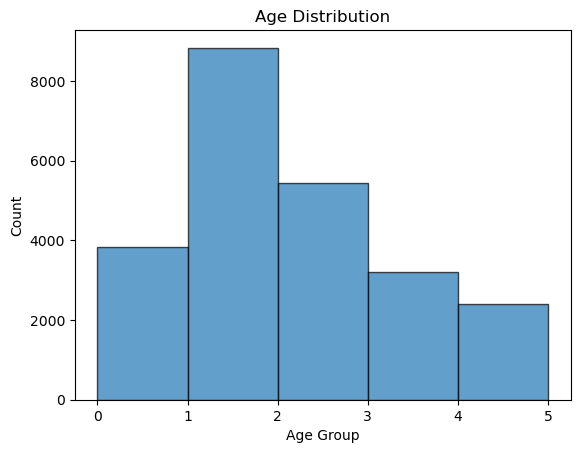

In [8]:
# Age Distribution
plt.hist(label_ages, bins=[0, 1, 2, 3, 4, 5], edgecolor='black', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

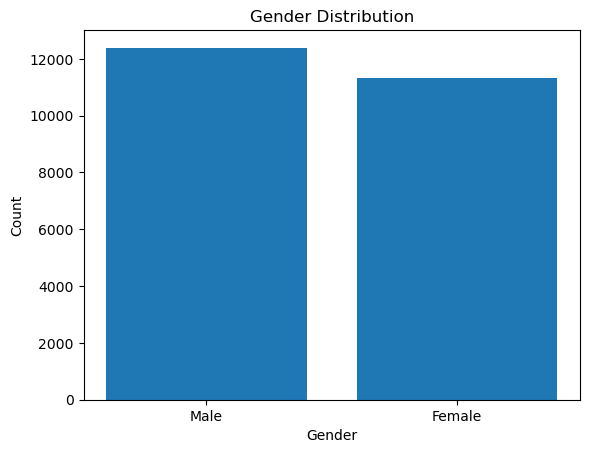

In [9]:
# Visualize Gender Distribution
gender_labels = ["Male", "Female"]
gender_values, gender_counts = np.unique(genders, return_counts=True)
plt.bar(gender_labels, gender_counts)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [10]:
# Train-test split
X_train, X_test, y_train_age, y_test_age, y_train_gender, y_test_gender = train_test_split(
    pixels, label_ages, genders, test_size=0.2, random_state=0
)
X_val, y_val_age, y_val_gender = X_train[:2000], y_train_age[:2000], y_train_gender[:2000]


In [11]:
# Build Combined Age and Gender Prediction Model
input_combined = Input(shape=(128, 128, 1))
conv1 = Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(input_combined)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool1)
dense_1 = Dense(128, activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output_age = Dense(5, activation="softmax", name='age_out')(drop_1)
output_gender = Dense(1, activation="sigmoid", name='sex_out')(drop_1)

model_combined = Model(inputs=input_combined, outputs=[output_age, output_gender])
model_combined.compile(optimizer="adam",
                      loss={"age_out": "sparse_categorical_crossentropy", "sex_out": "binary_crossentropy"},
                      metrics={'age_out': 'accuracy', 'sex_out': 'accuracy'})
model_combined.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
# Define callbacks
fle_s = 'Age_Gender_Prediction.h5'
checkpoint = ModelCheckpoint(fle_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,
                             mode='auto', save_freq='epoch')
Early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpoint, Early_stop]

In [13]:
# Train Combined Age and Gender Prediction Model
history_combined = model_combined.fit(X_train, {'age_out': y_train_age, 'sex_out': y_train_gender},
                                      validation_data=(X_val, {'age_out': y_val_age, 'sex_out': y_val_gender}),
                                      batch_size=32, epochs=50, callbacks=callback_list, verbose=1)

Epoch 1/50
593/593 [==============================] - ETA: 0s - loss: 2.0693 - age_out_loss: 1.4951 - sex_out_loss: 0.5728 - age_out_accuracy: 0.4157 - sex_out_accuracy: 0.7190
Epoch 1: val_loss improved from inf to 1.61926, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 210s 297ms/step - loss: 2.0693 - age_out_loss: 1.4951 - sex_out_loss: 0.5728 - age_out_accuracy: 0.4157 - sex_out_accuracy: 0.7190 - val_loss: 1.6193 - val_age_out_loss: 1.1883 - val_sex_out_loss: 0.4296 - val_age_out_accuracy: 0.5220 - val_sex_out_accuracy: 0.8100
Epoch 2/50
593/593 [==============================] - ETA: 0s - loss: 1.5821 - age_out_loss: 1.1561 - sex_out_loss: 0.4245 - age_out_accuracy: 0.5012 - sex_out_accuracy: 0.7927
Epoch 2: val_loss improved from 1.61926 to 1.38445, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 175s 295ms/step - loss: 1.5821 - age_out_loss: 1.1561 - sex_out_loss: 0.4245 - age_out_accuracy: 0.5012 - sex_ou

593/593 [==============================] - ETA: 0s - loss: 0.9810 - age_out_loss: 0.7534 - sex_out_loss: 0.2225 - age_out_accuracy: 0.6651 - sex_out_accuracy: 0.8935
Epoch 15: val_loss improved from 0.79728 to 0.75629, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 173s 293ms/step - loss: 0.9810 - age_out_loss: 0.7534 - sex_out_loss: 0.2225 - age_out_accuracy: 0.6651 - sex_out_accuracy: 0.8935 - val_loss: 0.7563 - val_age_out_loss: 0.5881 - val_sex_out_loss: 0.1629 - val_age_out_accuracy: 0.7795 - val_sex_out_accuracy: 0.9490
Epoch 16/50
593/593 [==============================] - ETA: 0s - loss: 0.9554 - age_out_loss: 0.7365 - sex_out_loss: 0.2136 - age_out_accuracy: 0.6720 - sex_out_accuracy: 0.8989
Epoch 16: val_loss improved from 0.75629 to 0.69753, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 173s 292ms/step - loss: 0.9554 - age_out_loss: 0.7365 - sex_out_loss: 0.2136 - age_out_accuracy: 0.6720 - sex_out_ac

Epoch 30/50
593/593 [==============================] - ETA: 0s - loss: 0.7352 - age_out_loss: 0.5673 - sex_out_loss: 0.1591 - age_out_accuracy: 0.7473 - sex_out_accuracy: 0.9298
Epoch 30: val_loss improved from 0.51345 to 0.48561, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 173s 292ms/step - loss: 0.7352 - age_out_loss: 0.5673 - sex_out_loss: 0.1591 - age_out_accuracy: 0.7473 - sex_out_accuracy: 0.9298 - val_loss: 0.4856 - val_age_out_loss: 0.3869 - val_sex_out_loss: 0.0898 - val_age_out_accuracy: 0.8540 - val_sex_out_accuracy: 0.9725
Epoch 31/50
593/593 [==============================] - ETA: 0s - loss: 0.7086 - age_out_loss: 0.5502 - sex_out_loss: 0.1494 - age_out_accuracy: 0.7550 - sex_out_accuracy: 0.9337
Epoch 31: val_loss improved from 0.48561 to 0.46584, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 173s 292ms/step - loss: 0.7086 - age_out_loss: 0.5502 - sex_out_loss: 0.1494 - age_out_accuracy: 0.7550 

Epoch 45/50
593/593 [==============================] - ETA: 0s - loss: 0.5991 - age_out_loss: 0.4577 - sex_out_loss: 0.1295 - age_out_accuracy: 0.7981 - sex_out_accuracy: 0.9445
Epoch 45: val_loss improved from 0.35907 to 0.35020, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 174s 293ms/step - loss: 0.5991 - age_out_loss: 0.4577 - sex_out_loss: 0.1295 - age_out_accuracy: 0.7981 - sex_out_accuracy: 0.9445 - val_loss: 0.3502 - val_age_out_loss: 0.2746 - val_sex_out_loss: 0.0637 - val_age_out_accuracy: 0.9130 - val_sex_out_accuracy: 0.9845
Epoch 46/50
593/593 [==============================] - ETA: 0s - loss: 0.5782 - age_out_loss: 0.4424 - sex_out_loss: 0.1238 - age_out_accuracy: 0.8042 - sex_out_accuracy: 0.9479
Epoch 46: val_loss improved from 0.35020 to 0.32015, saving model to Age_Gender_Prediction.h5
593/593 [==============================] - 175s 294ms/step - loss: 0.5782 - age_out_loss: 0.4424 - sex_out_loss: 0.1238 - age_out_accuracy: 0.8042 

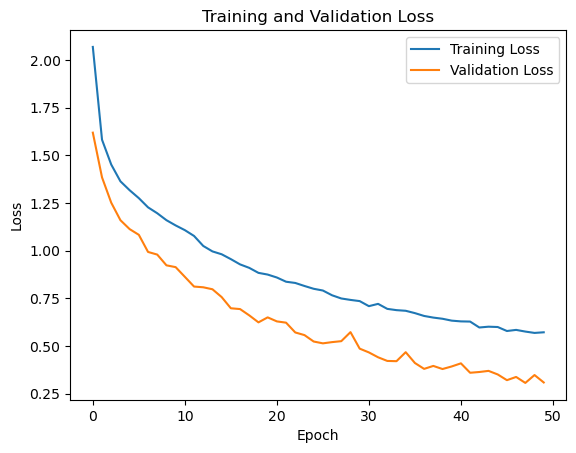

In [14]:
# Plot training and validation loss
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

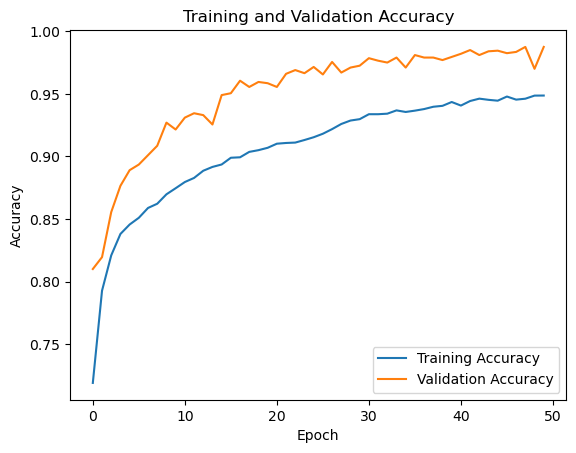

In [29]:
# Plot training and validation accuracy
plt.plot(history_combined.history['sex_out_accuracy'], label='Training Accuracy')
plt.plot(history_combined.history['val_sex_out_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
# Evaluate on test set
test_results = model_combined.evaluate(X_test, {'age_out': y_test_age, 'sex_out': y_test_gender})
test_loss = test_results[0]
age_loss = test_results[1]
test_loss = test_results[2]
test_accuracy = test_results[4]

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


149/149 [==============================] - 5s 31ms/step - loss: 2.1066 - age_out_loss: 1.5635 - sex_out_loss: 0.5304 - age_out_accuracy: 0.6288 - sex_out_accuracy: 0.8804
Test Loss: 0.5304047465324402
Test Accuracy: 0.8804302215576172


In [31]:
# Predictions on the test set
y_pred_age, y_pred_gender = model_combined.predict(X_test)

149/149 [==============================] - 5s 30ms/step


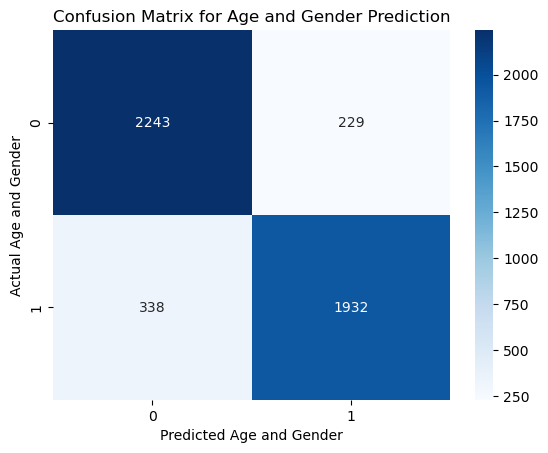

In [35]:
# Confusion Matrix
gender_conf_matrix = confusion_matrix(y_test_gender, y_pred_gender_class)
sns.heatmap(gender_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Age and Gender Prediction')
plt.xlabel('Predicted Age and Gender')
plt.ylabel('Actual Age and Gender')
plt.show()


In [36]:
# Classification Report for Gender
gender_classification_report = classification_report(y_test_gender, y_pred_gender_class)
print('Classification Report for Age and Gender:\n', gender_classification_report)

Classification Report for Age and Gender:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2472
           1       0.89      0.85      0.87      2270

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [39]:
# Print accuracy in percentage
accuracy_percentage = (gender_conf_matrix.diagonal().sum() / gender_conf_matrix.sum()) * 100

print(f'Age and Gender Prediction Accuracy: {accuracy_percentage:.2f}%')

Age and Gender Prediction Accuracy: 88.04%


In [40]:
# Save the model
model_combined.save('Age_Gender_Prediction_Model2.h5')